## Import module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
sns.set(style = "whitegrid", color_codes = True)
sns.set(font_scale = 1)
#from astropy.table import Table, Column
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import BernoulliNB
#import xgboost as xgb

from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import clone

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import model_selection

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, mean_squared_error
import pickle
import random
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

%load_ext autotime

/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from dodoml.pipeline import (
    ColumnsSelector, UniqueCountColumnSelector, TolerantLabelEncoder, FillNaN,
    ColumnApplier, OrdinalEncoder, CountFrequencyEncoder, Logify, BoxCoxTransformer,
    YToLog, TolerantLE)
from dodoml import compute_features_impact, compute_partial_dependence, lift_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from dodoml.pipeline import StackedModel
import category_encoders as ce

from sklearn.metrics import auc, roc_curve, roc_auc_score
from dodoml import compute_ace
import sys
sys.path.append("../../src")
#from utils import read_articles, read_cols, read_transactions, read_clients


time: 656 ms


In [3]:
from utils.stacking import StackingClassifier
from utils.pipeline import TargetEncoder

time: 153 ms


In [4]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Drop specified columns 
    """
    def __init__(self, drop_cols):
        self.drop_cols = list(drop_cols)
    
    def fit(self, X, y=None):
        self.kept_columns = list(set(X.columns) - set(self.drop_cols))
        return self
    
    def transform(self, X):
        return X[self.kept_columns]

time: 16.6 ms


In [5]:
class AddNewFeatures(BaseEstimator, TransformerMixin):
    
    #def __init__(self):
        
    def fit(self, X, y= None):
        # X['ps_ind_sum_bin'] = X[BIN].sum(axis = 1 )
        # X['ps_reg_mult'] = X.ps_reg_01 * X.ps_reg_02 * X.ps_reg_03
        # X['ps_car_13_ps_reg_03']= X.ps_car_13* X.ps_reg_03
        X['ps_car_15_carre'] = (X.ps_car_15)**2
        X['ps_car_14_carre'] = (X.ps_car_14)**2
        X['ps_car_12_carre'] = round((X.ps_car_12)**2,4) * 10000
        X['ps_car_13_carre'] = (X.ps_car_13)**2 * 48400
        X['ps_reg_03_carre'] = (4*X.ps_reg_03)**2
        return self

    def transform(self, X):
        X['ps_car_15_carre'] = (X.ps_car_15)**2
        X['ps_car_14_carre'] = (X.ps_car_14)**2
        X['ps_car_12_carre'] = round((X.ps_car_12)**2,4) * 10000
        X['ps_car_13_carre'] = (X.ps_car_13)**2 * 48400
        X['ps_reg_03_carre'] = (4*X.ps_reg_03)**2
        return X

time: 49.3 ms


## Import Data

In [6]:
#Import training data
train = pd.read_csv("data/train.csv")
#Import test data
test = pd.read_csv("data/test.csv")

time: 32.6 s


In [7]:
ytrain = train.target
train.drop('target', axis = 1, inplace = True)
idTest = test.id

time: 232 ms


## Split training data set into 2 part: train et test

In [17]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train, ytrain, test_size = 0.2)

time: 1.56 s


## Stacking with randomized Search

In [18]:
drop_columns = ['id', 'ps_calc_10', 'ps_calc_01', 'ps_calc_04', 'ps_car_02_cat', 'ps_calc_14',
               'ps_calc_08', 'ps_calc_17_bin', 'ps_car_10_cat', 'ps_ind_11_bin', 'ps_calc_12',
               'ps_calc_09', 'ps_car_06_cat', 'ps_calc_05','ps_calc_16_bin', 'ps_calc_20_bin',
                'ps_calc_18_bin', 'ps_car_15','ps_car_14', 'ps_car_12','ps_car_13', 'ps_reg_03']

#train.drop(drop_columns, axis = 1, inplace = True)
#test.drop(drop_columns, axis = 1, inplace = True)

time: 11 ms


In [19]:
CAT = []
NONCAT = []
BIN = []
CALC = []

for col in Xtrain.columns:
    if col not in drop_columns:
        if 'cat' in col:
            CAT.append(col)
        else:
            NONCAT.append(col)
            
        if 'bin' in col:
            BIN.append(col)
            
        if 'calc' in col:
            CALC.append(col)



time: 23.3 ms


### Fit model

In [12]:
from dodoml.ml import Hyperband
from scipy.stats.distributions import uniform, randint

param_space = {
    'learning_rate': [0.01, 0.03, 0.07, 0.1],
    'max_depth': randint(2, 11),
    'min_child_weight': randint(1, 11),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9),
    'colsample_bylevel': uniform(0.1, 0.9),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 10),
    'base_score': uniform(0.1, 0.9),
    'scale_pos_weight': uniform(0.1, 9.9)
}

time: 121 ms


In [21]:
first_level = make_pipeline(
                #AddNewFeatures(),
                #DropColumns(drop_cols= drop_columns),
                Hyperband(
                    XGBClassifier(learning_rate=0.03),
                    feat_space=param_space,
                    task='classification'
                )
            )

time: 2.13 ms


In [22]:
model_final = make_pipeline(
                AddNewFeatures(), # add new features 
                DropColumns(drop_cols= drop_columns), #drop columns
                make_union(
                    make_pipeline (
                        #ColumnsSelector(CAT),
                        TargetEncoder(CAT)
                        #ColumnApplier(TolerantLE()),
                        #OneHotEncoder(sparse= False)
                    ),
                    make_pipeline(
                        ColumnsSelector(NONCAT),
                        Imputer(missing_values= -1, strategy= 'mean')
                    )
                ),
                StackingClassifier(
                    {
                    'level 1': first_level,
                    'xgb': XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                                      min_child_weight=1, seed=88888), 
                    #random forest' : RandomForestClassifier(n_estimators=800, criterion='gini'),
                    'lgb' : LGBMClassifier(learning_rate= 0.01,n_estimators= 1250, max_bin= 10, subsample= 0.8, 
                                      subsample_freq = 10, colsample_bytree = 0.8, max_depth = 10)
                    },
                    meta_model= 
                    RandomizedSearchCV(
                                    XGBClassifier(),
                                    param_distributions = {'n_estimators' : [30, 100, 300, 800],
                                                            'max_depth' : [ 3, 5, 7, 9],
                                                            'learning_rate' : [0.3, 0.5, 0.1],
                                                            'silent' : [True, False],
                                                            'colsample_bytree' : [0.6, 0.85, 1]
                                                          },
                                    cv = 5,
                                    #verbose = 1,
                                    ), 
                    cv= model_selection.StratifiedKFold(n_splits=5, random_state=115, shuffle=True))
                )

time: 50.3 ms


In [ ]:
model_final.fit(Xtrain, Ytrain)

In [ ]:
pickle.dumps(model_final, open('final_model', 'wb'))

In [ ]:
y_predict = pd.DataFrame(model_final.predict_proba(Xtest))

### play around with pipeline

In [13]:
first_model = make_pipeline(
                AddNewFeatures(),
                DropColumns(drop_cols= drop_columns),
                Hyperband(
                    XGBClassifier(learning_rate=0.03),
                    feat_space=param_space,
                    task='classification'
                )
            )

time: 2.44 ms


In [14]:
second_model = make_pipeline(
                AddNewFeatures(),
                DropColumns(drop_cols= drop_columns),
                make_union(
                    make_pipeline (
                        #ColumnsSelector(CAT),
                        TargetEncoder(CAT)
                        #ColumnApplier(TolerantLE()),
                        #OneHotEncoder(sparse= False)
                    ),
                    make_pipeline(
                        ColumnsSelector(NONCAT),
                        Imputer(missing_values= -1, strategy= 'mean')
                    )
                ),
                XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                                      min_child_weight=1, seed=88888)
                
                )

time: 6.8 ms


In [22]:
pipeline_model = make_pipeline(
                StackingClassifier(
                    {
                    'model 1': first_model,
                    'model 2': XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                                      min_child_weight=1, seed=88888)
                    },
                    meta_model= LogisticRegression(),
                    cv= model_selection.StratifiedKFold(n_splits=5, random_state=115, shuffle=True)
                    )            
                )

time: 5.13 ms


In [23]:
pipeline_model.fit(Xtrain, Ytrain)

AttributeError: 'numpy.ndarray' object has no attribute 'ps_car_15'

time: 1.01 s


### feature impact importance

In [16]:
feature_impact = compute_features_impact(xgb_rs, Xtest, Ytest, row_sample= 500000)

NameError: name 'Xtest' is not defined

time: 8.36 ms


In [38]:
feature_impact.sort_values()

ps_calc_10       -5.738022e-04
ps_calc_01       -4.931497e-04
ps_calc_04       -3.074811e-04
ps_car_02_cat    -2.429297e-04
ps_calc_14       -1.633999e-04
ps_calc_08       -1.536811e-04
ps_calc_17_bin   -1.397705e-04
ps_car_10_cat    -9.044179e-05
ps_ind_11_bin    -8.745112e-05
ps_calc_12       -7.856055e-05
ps_calc_09       -6.295272e-05
ps_car_06_cat    -5.750220e-05
ps_calc_05       -5.008816e-05
ps_calc_16_bin   -3.968973e-05
ps_calc_20_bin   -8.212586e-06
ps_calc_18_bin   -2.317374e-07
ps_ind_10_bin     0.000000e+00
ps_calc_19_bin    1.219283e-05
ps_ind_13_bin     1.484529e-05
ps_calc_03        2.944161e-05
ps_calc_06        4.819825e-05
ps_calc_13        6.399241e-05
ps_ind_14         6.951183e-05
ps_ind_18_bin     9.094754e-05
ps_calc_15_bin    9.361409e-05
ps_calc_11        1.576770e-04
ps_car_05_cat     1.689350e-04
ps_car_14         1.693922e-04
ps_ind_12_bin     1.846571e-04
ps_car_08_cat     4.538797e-04
ps_calc_02        5.060425e-04
ps_calc_07        5.910150e-04
ps_car_0

time: 4.79 ms


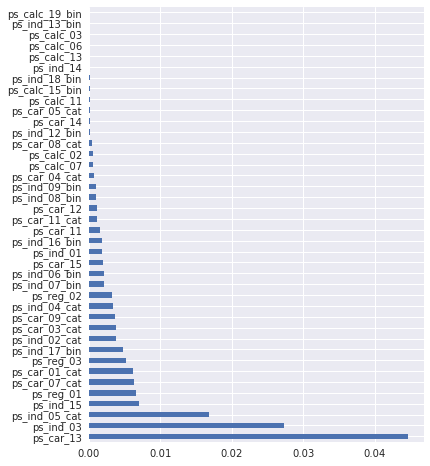

time: 635 ms


In [39]:
plt.figure(figsize=(6,8))
feature_impact[feature_impact > 0].plot(kind = 'barh')

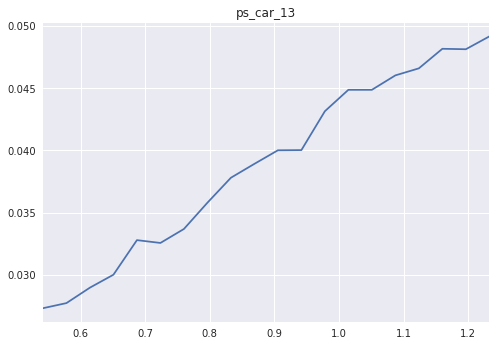

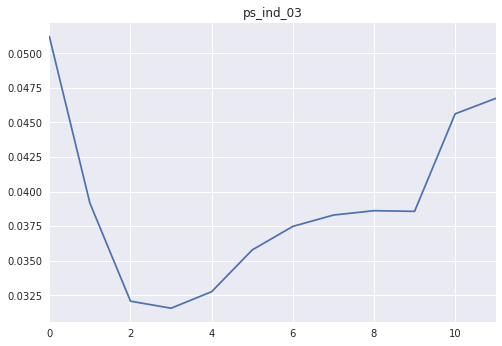

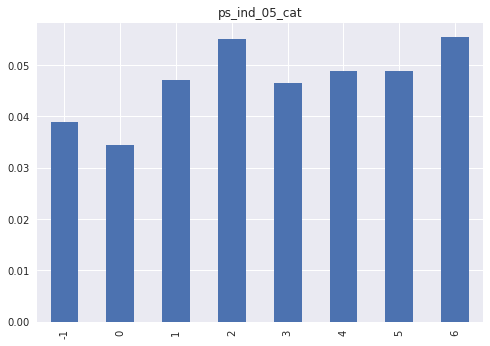

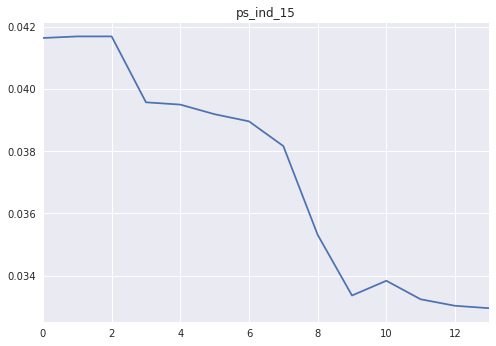

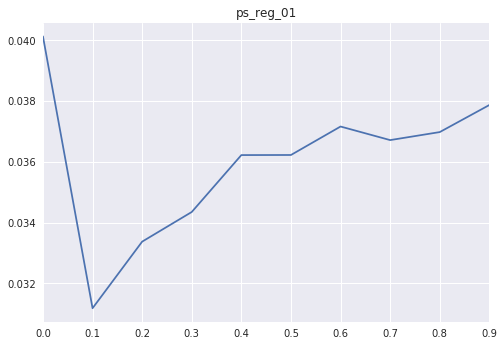

time: 1min 8s


In [75]:
for feature, series in compute_partial_dependence(xgb_rs, Xtest, features= ['ps_car_13', 'ps_ind_03', 'ps_ind_05_cat','ps_ind_15','ps_reg_01'], row_sample = 100000 ):
    if series.shape[0] > 0:
        if feature in ['ps_ind_05_cat']:
            series.plot(kind='bar')
        else:
            series.plot(kind='line')
        plt.title(feature)
        plt.show()

## XGboost with Hyperband

### fit model xgboost with hyperband

In [25]:
from dodoml.ml import Hyperband
from scipy.stats.distributions import uniform, randint

param_space = {
    'learning_rate': [0.01, 0.03, 0.07, 0.1],
    'max_depth': randint(2, 11),
    'min_child_weight': randint(1, 11),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9),
    'colsample_bylevel': uniform(0.1, 0.9),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 10),
    'base_score': uniform(0.1, 0.9),
    'scale_pos_weight': uniform(0.1, 9.9)
}

model = make_pipeline(
    Hyperband(
        XGBClassifier(learning_rate=0.1),
        feat_space=param_space,
        task='classification'
    )
)

time: 16 ms


In [26]:
model.fit(Xtrain, Ytrain)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e516a0>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e51898>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e518d0>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handl

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e51eb8>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e51c50>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f5094e51e48>>
Traceback (most recent call last):
  File "/home/tu/miniconda3/envs/myenv/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/core.py", line 366, in __del__
    if self.handl

Pipeline(memory=None,
     steps=[('hyperband', Hyperband(feat_space={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094982630>, 'base_score': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978be0>, 'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978a20>, 'gamma': <scipy.stats._distn_in...982400>, 'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978da0>},
     max_iter=81, model=None, task='classification'))])

time: 35min 54s


### best parameters

In [40]:
model.steps[-1][-1]

Hyperband(feat_space={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094982630>, 'base_score': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978be0>, 'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978a20>, 'gamma': <scipy.stats._distn_in...982400>, 'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5094978da0>},
     max_iter=81, model=None, task='classification')

time: 2.47 ms


### predict test

In [31]:
y_pred_xgb_hb = model.predict_proba(test)[:,1]

time: 7.88 s


In [33]:
pd.DataFrame({"id": idTest, "target": y_pred_xgb_hb}).to_csv('predict_issurance_2.csv', index=False)

time: 2.03 s


### feature impact

In [68]:
feature_impact_hb = compute_features_impact(model, Xtest, Ytest, row_sample= 500000)

time: 36.6 s


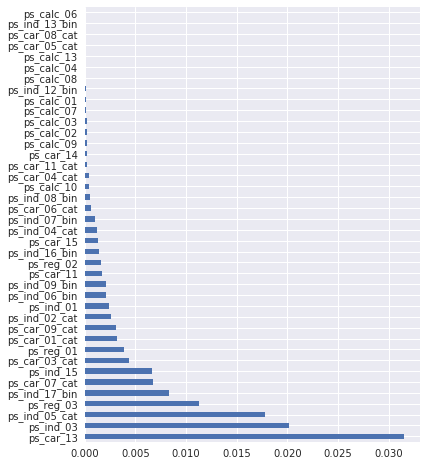

time: 606 ms


In [72]:
plt.figure(figsize=(6,8))
feature_impact_hb[feature_impact_hb > 0].plot(kind = 'barh')

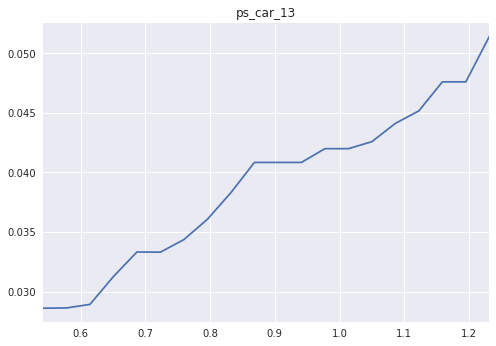

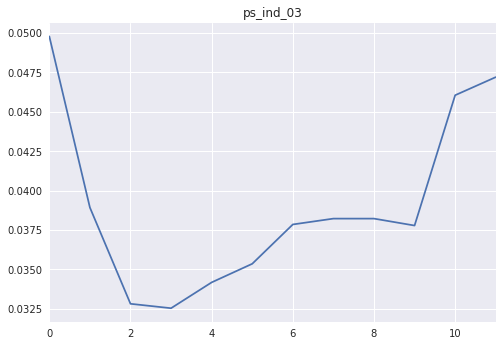

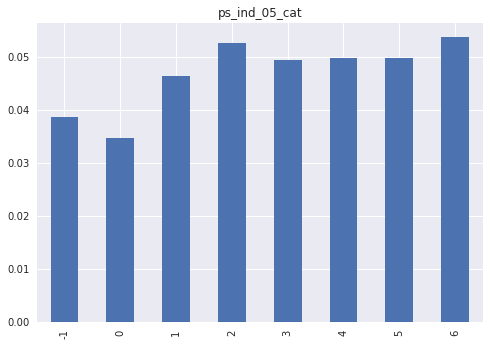

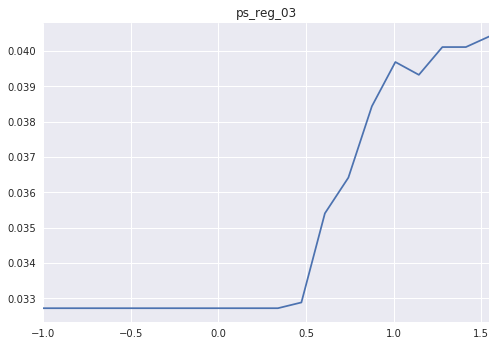

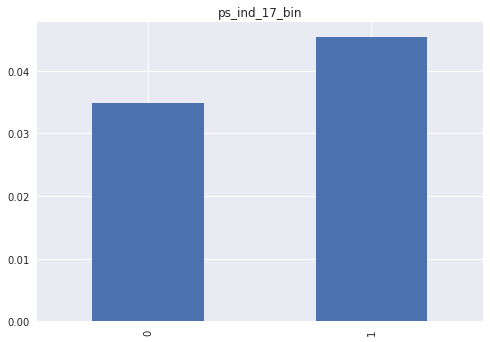

time: 32 s


In [74]:
for feature, series in compute_partial_dependence(model, Xtest, features= ['ps_car_13', 'ps_ind_03', 'ps_ind_05_cat','ps_reg_03','ps_ind_17_bin'], row_sample = 100000 ):
    if series.shape[0] > 0:
        if feature in ['ps_ind_05_cat','ps_ind_17_bin']:
            series.plot(kind='bar')
        else:
            series.plot(kind='line')
        plt.title(feature)
        plt.show()

## Bayesian Optimization of XGBoost Parameters

In [9]:
from bayes_opt import BayesianOptimization

time: 3.06 ms


In [10]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import contextlib

time: 2.64 ms


In [14]:
def scale_data(X, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

time: 3.09 ms


In [11]:
DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

def load_data(path_train=DATA_TRAIN_PATH, path_test=DATA_TEST_PATH):
    train_loader = pd.read_csv(path_train, dtype={'target': np.int8, 'id': np.int32})
    train = train_loader.drop(['target', 'id'], axis=1)
    train_labels = train_loader['target'].values
    train_ids = train_loader['id'].values
    print('\n Shape of raw train data:', train.shape)

    test_loader = pd.read_csv(path_test, dtype={'id': np.int32})
    test = test_loader.drop(['id'], axis=1)
    test_ids = test_loader['id'].values
    print(' Shape of raw test data:', test.shape)

    return train, train_labels, test, train_ids, test_ids

time: 13.6 ms


In [12]:
def XGB_CV(max_depth, gamma,
           min_child_weight,
           max_delta_step,
           subsample,
           colsample_bytree):

    global AUCbest
    global ITERbest

#
# Define all XGboost parameters
#

    paramt = {
              'booster' : 'gbtree',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 1001
              }

    folds = 5
    cv_score = 0

    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()

    xgbc = xgb.cv(
                    paramt,
                    dtrain,
                    num_boost_round = 20000,
                    stratified = True,
                    nfold = folds,
#                    verbose_eval = 10,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )

# This line would have been on top of this section
#    with capture() as result:

# After xgb.cv is done, this section puts its output into log file. Train and validation scores 
# are also extracted in this section. Note the "diff" part in the printout below, which is the 
# difference between the two scores. Large diff values may indicate that a particular set of 
# parameters is overfitting, especially if you check the CV portion of it in the log file and find 
# out that train scores were improving much faster than validation scores.

#    print('', file=log_file)
#    for line in result[1]:
#        print(line, file=log_file)
#    log_file.flush()

    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    print(' Stopped after %d iterations with train-auc = %f val-auc = %f ( diff = %f ) train-gini = %f val-gini = %f' % ( len(xgbc), train_score, val_score, (train_score - val_score), (train_score*2-1),
(val_score*2-1)) )
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score*2) - 1

time: 59.9 ms


In [18]:
# Define the log file. If you repeat this run, new output will be added to it
log_file = open('Porto-AUC-5fold-XGB-run-01-v1-full.log', 'a')
AUCbest = -1.
ITERbest = 0

# Load data set and target values
train, target, test, tr_ids, te_ids = load_data()
n_train = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
col_to_drop = train.columns[train.columns.str.endswith('_cat')]
col_to_dummify = train.columns[train.columns.str.endswith('_cat')].astype(str).tolist()

for col in col_to_dummify:
    dummy = pd.get_dummies(train_test[col].astype('category'))
    columns = dummy.columns.astype(str).tolist()
    columns = [col + '_' + w for w in columns]
    dummy.columns = columns
    train_test = pd.concat((train_test, dummy), axis=1)

train_test.drop(col_to_dummify, axis=1, inplace=True)
train_test_scaled, scaler = scale_data(train_test)
train = train_test_scaled[:n_train, :]
test = train_test_scaled[n_train:, :]
print('\n Shape of processed train data:', train.shape)
print(' Shape of processed test data:', test.shape)

# We really didn't need to load the test data in the first place unless you are planning to make
# a prediction at the end of this run.
# del test
# gc.collect()


 Shape of raw train data: (595212, 57)
 Shape of raw test data: (892816, 57)

 Shape of processed train data: (595212, 227)
 Shape of processed test data: (892816, 227)
time: 33.6 s


In [19]:
# dtrain = xgb.DMatrix(train, label = target)

sss = StratifiedShuffleSplit(target, random_state=1001, test_size=0.75)
for train_index, test_index in sss:
    break
X_train, y_train = train[train_index], target[train_index]
del train, target
gc.collect()
dtrain = xgb.DMatrix(X_train, label = y_train)


time: 866 ms


In [20]:
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0)
                                    })


time: 2.37 ms


In [21]:
XGB_BO.explore({
              'max_depth':            [3, 8, 3, 8, 8, 3, 8, 3],
              'gamma':                [0.5, 8, 0.2, 9, 0.5, 8, 0.2, 9],
              'min_child_weight':     [0.2, 0.2, 0.2, 0.2, 12, 12, 12, 12],
              'max_delta_step':       [1, 2, 2, 1, 2, 1, 1, 2],
              'subsample':            [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
              'colsample_bytree':     [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
              })

time: 3.51 ms


In [22]:
print('-'*130)
print('-'*130, file=log_file)
log_file.flush()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=2, n_iter=5, acq='ei', xi=0.0)

----------------------------------------------------------------------------------------------------------------------------------
Initialization
----------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_delta_step |   max_depth |   min_child_weight |   subsample | 
 Stopped after 143 iterations with train-auc = 0.682293 val-auc = 0.632955 ( diff = 0.049338 ) train-gini = 0.364586 val-gini = 0.265910
    1 | 07m16s |    0.26591 |             0.6000 |    0.5000 |           1.0000 |      3.0000 |             0.2000 |      0.6000 | 
 Stopped after 62 iterations with train-auc = 0.759147 val-auc = 0.628424 ( diff = 0.130724 ) train-gini = 0.518295 val-gini = 0.256847
    2 | 13m35s |    0.25685 |             0.8000 |    8.0000 |           2.0000 |      8.0000 |             0.2000 |      0.8000 | 
 Stopped after 110 iterations with train-auc = 0.67570

In [23]:
pickle.dump(XGB_BO, open('xgb_bo', 'wb'))

time: 2.22 ms


## Tree plot 

In [ ]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

In [23]:
from xgboost import plot_tree
model = XGBClassifier(max_depth = 3)
model.fit(train.drop(['id', 'target'],axis=1), train.target)
# plot single tree


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

time: 1min 16s


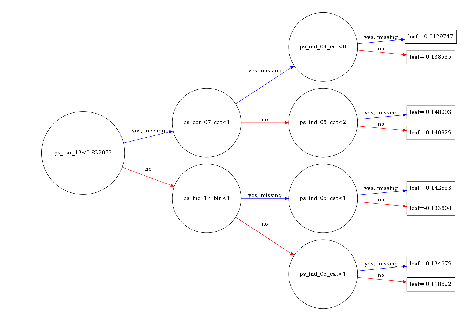

time: 539 ms


In [24]:
plot_tree(model, num_trees = 3, rankdir = 'LR')
plt.show()

## Test

In [43]:
import scipy.interpolate
import scipy.integrate

time: 1.04 ms


In [45]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

time: 16.5 ms


In [97]:
def calculate_gini(actual, predictions):
    # Sort the actual values by the predictions
    data = zip(Ytest, y_pred_xgb_rs[:,1])
    sorted_data = sorted(data, key=lambda d: d[1])
    sorted_actual = [d[0] for d in sorted_data]

    # Sum up the actual values
    cumulative_actual = np.cumsum(sorted_actual)
    cumulative_index = np.arange(1, len(cumulative_actual)+1)
    
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    
    ax[0].plot(cumulative_index, cumulative_actual)
    ax[0].set_xlabel('Cumulative Number of Predictions')
    ax[0].set_ylabel('Cumulative Actual Values')
    
    cumulative_actual_shares = cumulative_actual / sum(Ytest)
    cumulative_index_shares = cumulative_index / len(y_pred_xgb_rs[:,1])

    # Add (0, 0) to the plot
    x_values = [0] + list(cumulative_index_shares)
    y_values = [0] + list(cumulative_actual_shares)

    # Display the 45° line stacked on top of the y values
    diagonal = [x - y for (x, y) in zip(x_values, y_values)]

    ax[1].stackplot(x_values, y_values, diagonal)
    ax[1].set_xlabel('Cumulative Values of Predictions')
    ax[1].set_ylabel('Cumulative Values of Actual Values')
    
    gini_predictions = gini(actual, predictions)
    gini_max = gini(actual, actual)
    ngini= gini_normalized(actual, predictions)
    
    return [gini_predictions, gini_max, ngini]
    

time: 60 ms


[0.12961025758612835, 0.48156548474080796, 0.26914357796196342]

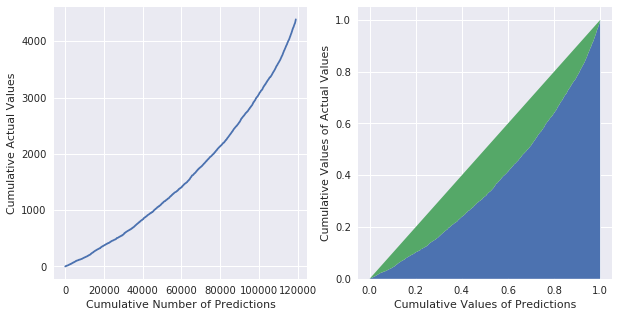

time: 1.03 s


In [98]:
calculate_gini(Ytest, y_pred_xgb_rs[:,1])

[0.12838131038144565, 0.48156548474080796, 0.2665915943924928]

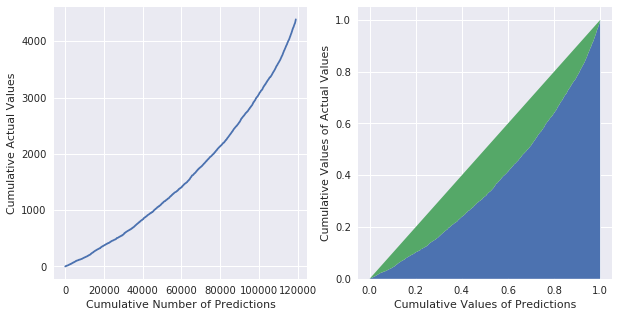

time: 925 ms


In [99]:
calculate_gini(Ytest, y_pred_xgb_hb[:,1])